In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import urllib.request, urllib.parse
from bs4 import BeautifulSoup

In [268]:
data = pd.read_csv("netflix_titles.csv/netflix_titles.csv")

In [269]:
rating_replacements = {
    211: 'TV-14',
    2411: 'TV-14',
    3288: 'PG-13',
    4056: 'TV-G',
    4402: 'TV-G',
    4403: 'TV-G',
    4706: 'TV-14',
    5015: 'TV-14',
    5234: 'TV-14',
    6231: 'TV-Y'
}

for id, rate in rating_replacements.items():
    data.iloc[id,8] = rate

In [270]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

target_ages = ["Kids","Older Kids","Teens","Adults"]

data["target_age"] = data["rating"].replace(ratings_ages)
data["target_age"] = pd.Categorical(data["target_age"],target_ages)

In [271]:
data["month_added"] = [str(date).split()[0] for date in data.date_added]

In [272]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   show_id       7787 non-null   object  
 1   type          7787 non-null   object  
 2   title         7787 non-null   object  
 3   director      5398 non-null   object  
 4   cast          7069 non-null   object  
 5   country       7280 non-null   object  
 6   date_added    7777 non-null   object  
 7   release_year  7787 non-null   int64   
 8   rating        7780 non-null   object  
 9   duration      7787 non-null   object  
 10  listed_in     7787 non-null   object  
 11  description   7787 non-null   object  
 12  target_age    7780 non-null   category
 13  month_added   7787 non-null   object  
dtypes: category(1), int64(1), object(12)
memory usage: 798.8+ KB


In [273]:
data["year_added"] = [str(date)[-4:] for date in data.date_added]

In [230]:
len(data)

7787

In [231]:
data.isnull().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
year_added         0
dtype: int64

# Get top 20 directors (by counts of movies directed)

<Figure size 1440x1080 with 0 Axes>

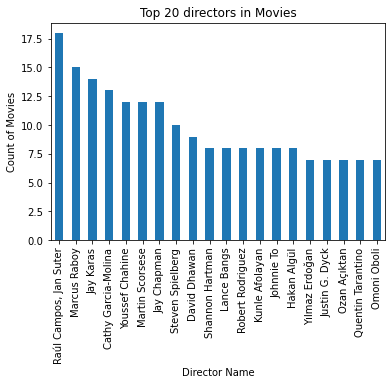

In [274]:
director_count_movies = data[["show_id"]][data["type"]=='Movie'].groupby(data.director).count().sort_values("show_id", ascending=False)
director_count_movies.rename(columns={"show_id":"count"}, inplace=True)

plt.figure(figsize=(20,15))
director_count_movies[:20].plot(kind="bar", legend=None)
plt.xlabel("Director Name")
plt.ylabel("Count of Movies")
plt.title("Top 20 directors in Movies")
plt.show()

# Get top 5 directors (by counts of TV Shows directed)

<Figure size 1440x1080 with 0 Axes>

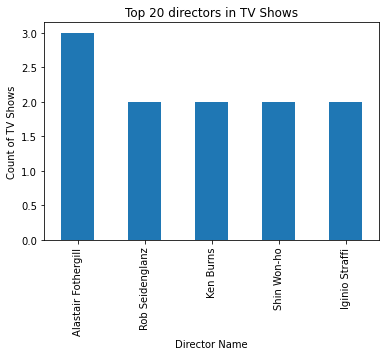

In [275]:
director_count_shows = data[["show_id"]][data["type"]=='TV Show'].groupby(data.director).count().sort_values("show_id", ascending=False)
director_count_shows.rename(columns={"show_id":"count"}, inplace=True)

plt.figure(figsize=(20,15))
director_count_shows[:5].plot(kind="bar", legend=None)
plt.xlabel("Director Name")
plt.ylabel("Count of TV Shows")
plt.title("Top 20 directors in TV Shows")
plt.show()

# Get count movies and TV shows released every year

In [276]:
data.year_added.unique()
year_data = data.drop(data[data["year_added"]=='nan'].index, axis=0)

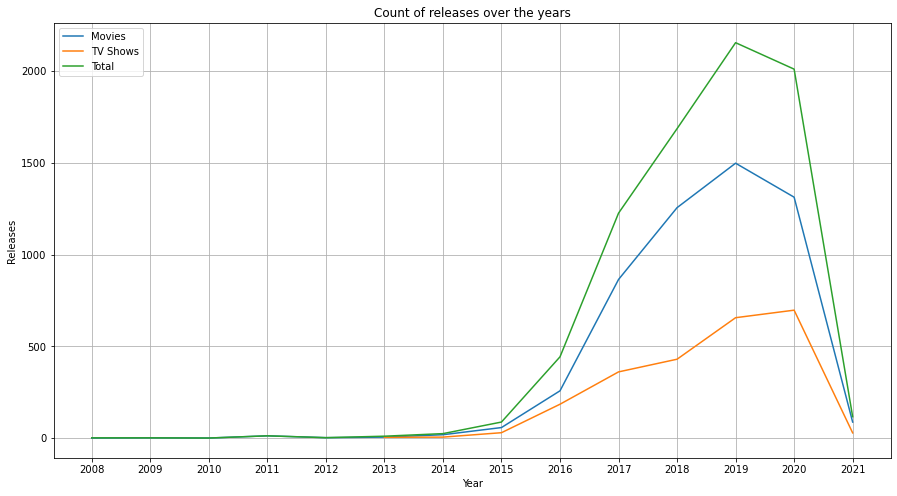

In [278]:
plt.figure(figsize=(15,8))
year_count = year_data[["show_id"]][year_data["type"]=='Movie'].groupby(year_data.year_added).count().sort_index(axis=0)
year_count.rename(columns={"show_id":"Movies"}, inplace=True)
year_count["TV Shows"] = year_data[["show_id"]][year_data["type"]=='TV Show'].groupby(year_data.year_added).count().sort_index(axis=0)
year_count["Total"] = year_data[["show_id"]].groupby(year_data.year_added).count().sort_index(axis=0)

#year_count.plot(kind="line", figsize=(15,8))
plt.grid()
plt.title("Count of releases over the years")
plt.xlabel("Year")
plt.ylabel("Releases")

plt.plot(year_count)
plt.legend(list(year_count.columns), loc="upper left")

# Correlation between genres for Movies and TV shows

In [279]:
movie_genres = set()
tv_genres = set()
for genre in data["listed_in"][data["type"]=='Movie']:
    genre = genre.split(", ")
    for i in range(0,len(genre)):
        movie_genres.add(genre[i])
for genre in data["listed_in"][data["type"]=='TV Show']:
    genre = genre.split(", ")
    for i in range(0,len(genre)):
        tv_genres.add(genre[i])

In [280]:
mg_data = pd.DataFrame(columns = movie_genres)
mg_data["show_id"] = data["show_id"][data["type"]=='Movie']
mg_data = pd.merge(mg_data,data[["show_id","listed_in"]],how='left',on='show_id')

In [281]:
for i in range(0, len(mg_data)):
    for genre in mg_data["listed_in"].iloc[i].split(", "):
        mg_data[genre].iloc[i] = 1

In [282]:
tvg_data = pd.DataFrame(columns = tv_genres)
tvg_data["show_id"] = data["show_id"][data["type"]=='TV Show']
tvg_data = pd.merge(tvg_data,data[["show_id","listed_in"]],how='left',on='show_id')

for i in range(0, len(tvg_data)):
    for genre in tvg_data["listed_in"].iloc[i].split(", "):
        tvg_data[genre].iloc[i] = 1

In [283]:
mg_data.fillna(0, inplace=True)
tvg_data.fillna(0, inplace=True)

In [284]:
mask1 = np.zeros_like(mg_data.corr(), dtype=np.bool)
mask1[np.triu_indices_from(mask1)] = True

mask2 = np.zeros_like(tvg_data.corr(), dtype=np.bool)
mask2[np.triu_indices_from(mask2)] = True

<Figure size 1440x720 with 0 Axes>

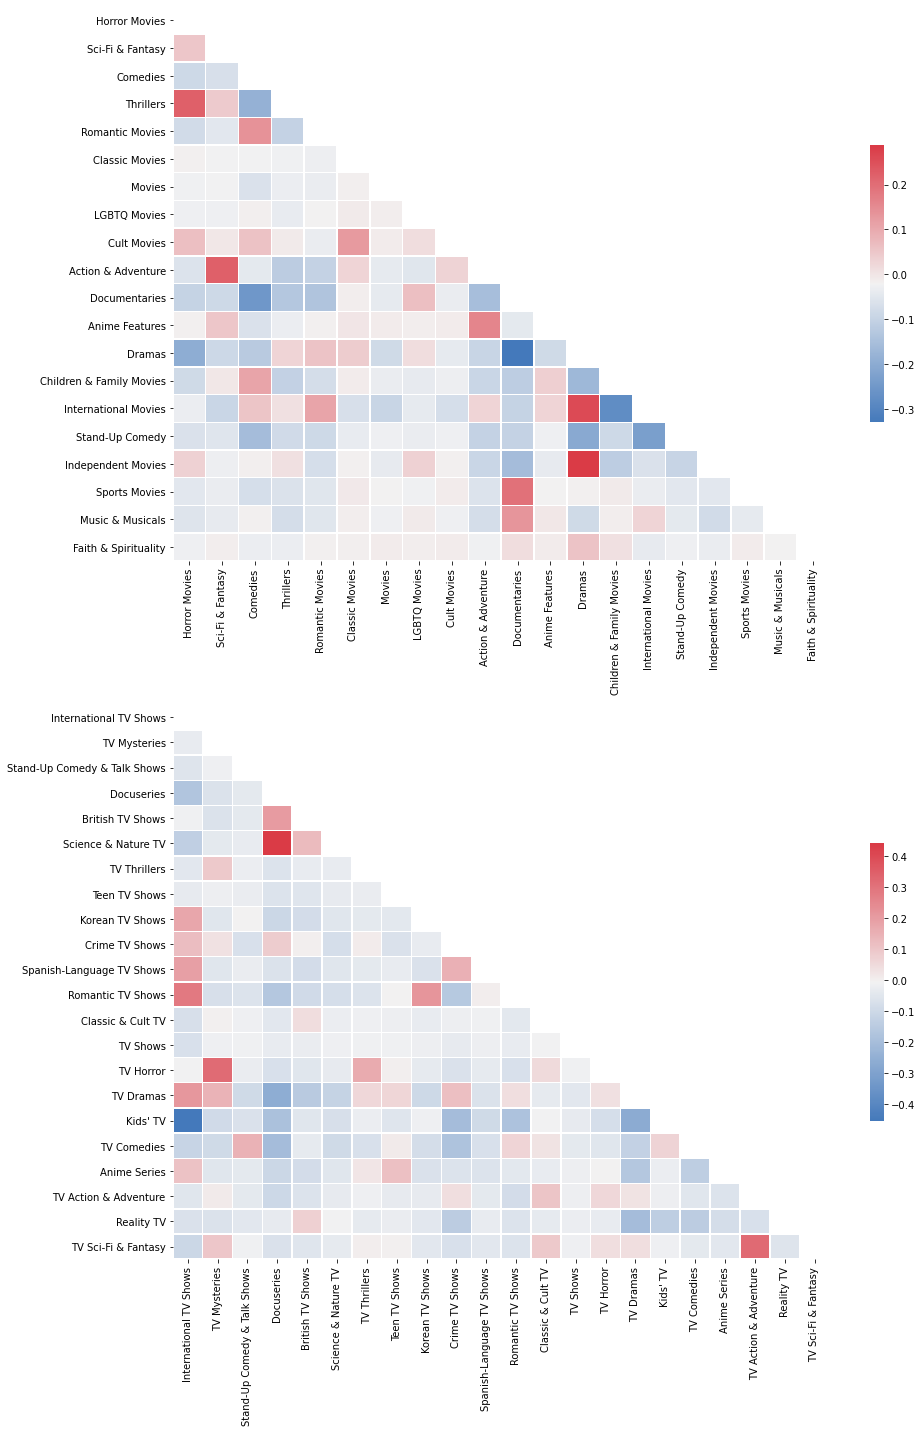

In [285]:
plt.figure(figsize = (20,10))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (14,20))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(mg_data.corr(), mask = mask1, cmap = cmap, ax=ax1, linewidths=.5, cbar_kws={"shrink":.5})
sns.heatmap(tvg_data.corr(), mask = mask2, cmap = cmap, ax=ax2, linewidths=.5, cbar_kws={"shrink":.5})
fig.tight_layout()

# Distribution of movies and TV shows based on genres

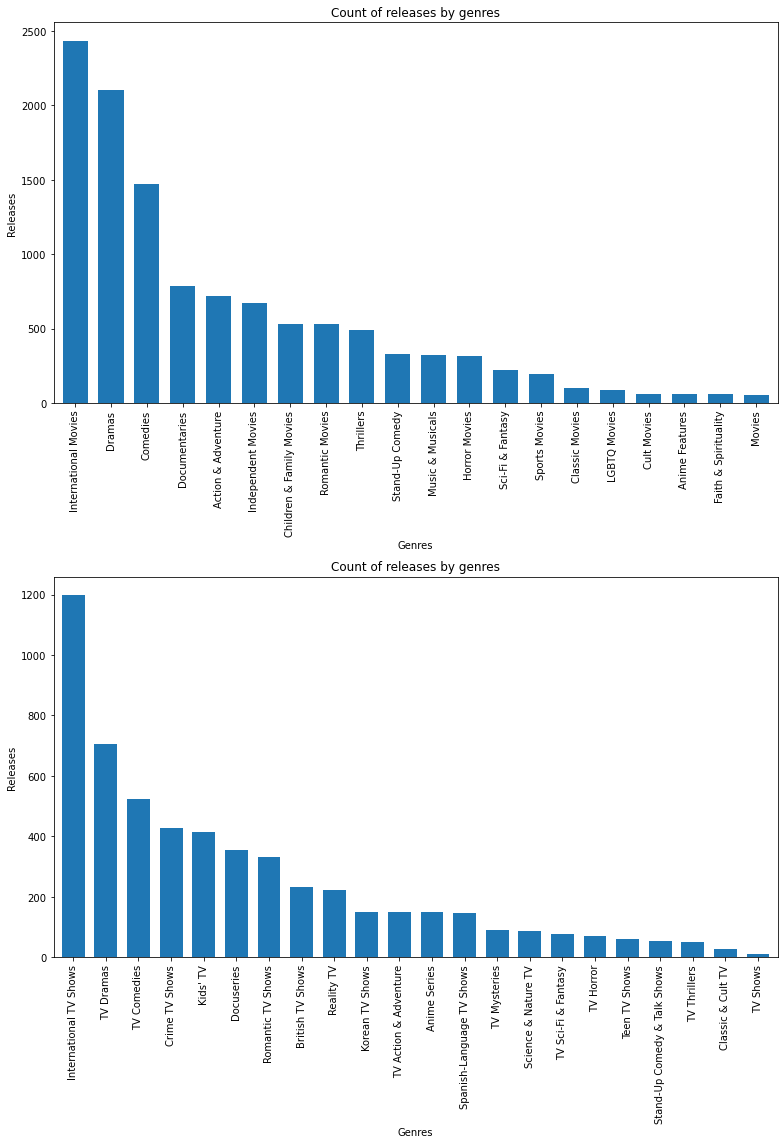

In [286]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(11,16))
mg_data.iloc[:,:-2].sum().sort_values(ascending=False).plot(kind="bar", ax=ax1, xlabel = "Genres", ylabel = "Releases", title="Count of releases by genres", width=0.7)
tvg_data.iloc[:,:-2].sum().sort_values(ascending=False).plot(kind="bar", ax=ax2, xlabel = "Genres", ylabel = "Releases", title="Count of releases by genres", width=0.7)
plt.tight_layout()

# Trend in the number of movies and tv show releases for each genre 

In [287]:
mg_data = pd.merge(mg_data, data[["show_id","year_added"]], how="left", on = "show_id")
tvg_data = pd.merge(tvg_data, data[["show_id","year_added"]], how="left", on = "show_id")

plt.figure(figsize=(20,14))
plt.plot(mg_data.iloc[:,:-3].groupby(mg_data.year_added).sum())
plt.legend(mg_data.iloc[:,:-3].columns)

plt.figure(figsize=(20,14))
plt.plot(mg_data.iloc[:,:-3].groupby(mg_data.year_added).sum().transpose())
plt.legend(mg_data.iloc[:,:-3].columns)

mg_year_data = mg_data.iloc[:,:-3].groupby(mg_data.year_added).sum()
plt.figure(figsize=(25,35))
#fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14,ax15)) = plt.subplots(5,3)
fig, ((ax6,ax7, ax8), (ax9,ax10, ax11), (ax12, ax13, ax14)) = plt.subplots(3,3)
ax = [ax6,ax7,ax8, ax9,ax10, ax11, ax12,ax13,ax14]
for i in range(6,len(mg_year_data)+1):
    mg_year_data.iloc[i-1,:].plot(kind="bar", ax=ax[i-6],figsize=(15,10), legend=True)
plt.tight_layout()

In [288]:
mg_year_data = mg_data.iloc[:,:-3].groupby(mg_data.year_added).sum()
#skip years before 2013 as they dont seem to have any significant data as compared to later years
mg_year_data = mg_year_data.iloc[5:-1,:]

<ipython-input-289-ac83e937fd7a>:16: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



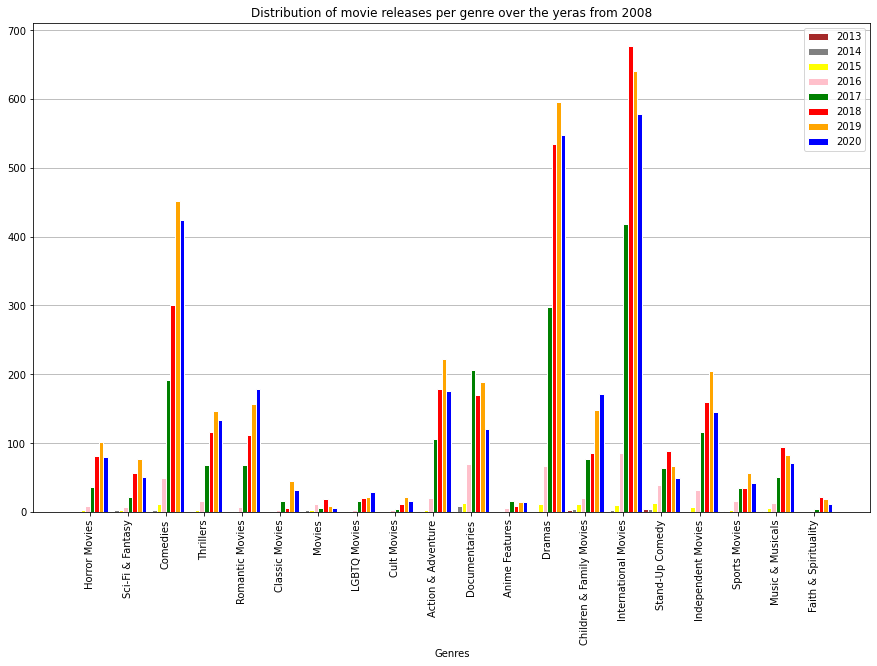

In [289]:
fig = plt.figure(figsize=(15,9))
barwidth = 0.12
bars = [mg_year_data.iloc[0,:]]
r = [np.arange(len(bars[0]))]
#r = [np.arange(0,60,3)]
color = ["brown","grey","yellow","pink","green","red","orange","blue"]
for col in range(1,len(mg_year_data.index)):
    bars.append(mg_year_data.iloc[col,:])
    r.append([x + barwidth for x in r[col-1]])
for i in range(len(bars)):
    plt.bar(r[i], bars[i], width = barwidth, edgecolor = "white",label = mg_year_data.index[i], color=color[i])
plt.xlabel("Genres")
plt.xticks([r + barwidth*((len(mg_year_data)-1)/2) for r in range(len(bars[0]))],list(mg_year_data.columns), rotation = 90)
plt.legend()
plt.title("Distribution of movie releases per genre over the yeras from 2008")
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.grid(axis="y")
plt.show()

In [290]:
tvg_year_data = tvg_data.iloc[:,:-3].groupby(mg_data.year_added).sum()
#skip years before 2015 as they dont seem to have any significant data as compared to later years
tvg_year_data = tvg_year_data.iloc[5:-1,:]

<ipython-input-291-6e996df31251>:16: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



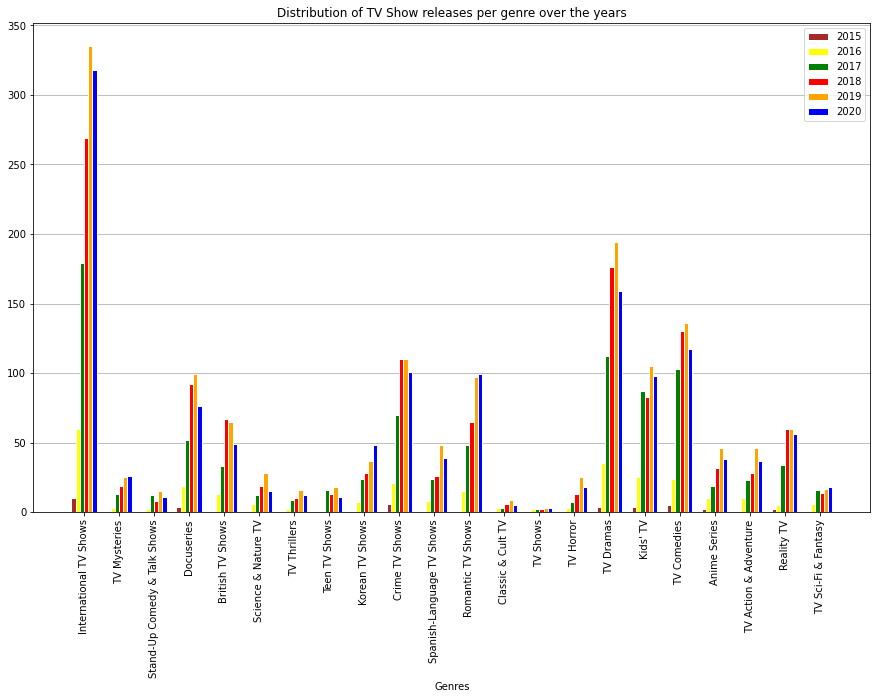

In [291]:
fig = plt.figure(figsize=(15,9))
barwidth = 0.12
bars = [tvg_year_data.iloc[0,:]]
r = [np.arange(len(bars[0]))]
#r = [np.arange(0,60,3)]
color = ["brown","yellow","green","red","orange","blue"]
for col in range(1,len(tvg_year_data.index)):
    bars.append(tvg_year_data.iloc[col,:])
    r.append([x + barwidth for x in r[col-1]])
for i in range(len(bars)):
    plt.bar(r[i], bars[i], width = barwidth, edgecolor = "white",label = tvg_year_data.index[i], color=color[i])
plt.xlabel("Genres")
plt.xticks([r + barwidth*((len(tvg_year_data)-1)/2) for r in range(len(bars[0]))],list(tvg_year_data.columns), rotation = 90)
plt.legend()
plt.title("Distribution of TV Show releases per genre over the years")
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.grid(axis="y")
plt.show()

# Distribution of TV Shows by number of seasons

Text(0, 0.5, 'Number of TV Shows')

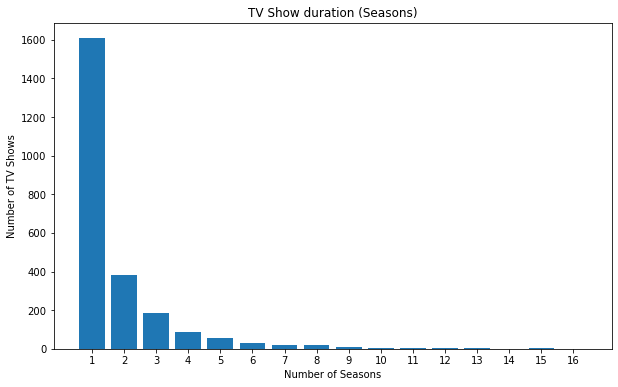

In [292]:
tv_duration = data[["show_id","duration"]][data["type"]=="TV Show"]
tv_duration["duration"] = [str(x).split()[0] for x in tv_duration["duration"]]

tv_duration = tv_duration[["show_id"]].groupby(tv_duration.duration).count()
tv_duration.rename(columns={"show_id":"TV Shows"}, inplace=True)
l = [str(i) for i in range(1,17)]
tv_duration = tv_duration.reindex(l,axis=0)
tv_duration["TV Shows"].fillna(0, inplace=True)
tv_duration.reset_index(inplace=True)

plt.figure(figsize=(10,6))
plt.bar(tv_duration["duration"],tv_duration["TV Shows"])

plt.title("TV Show duration (Seasons)")
plt.xlabel("Number of Seasons")
plt.ylabel("Number of TV Shows")

# Distribution of movie durations

C:\Users\monis\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



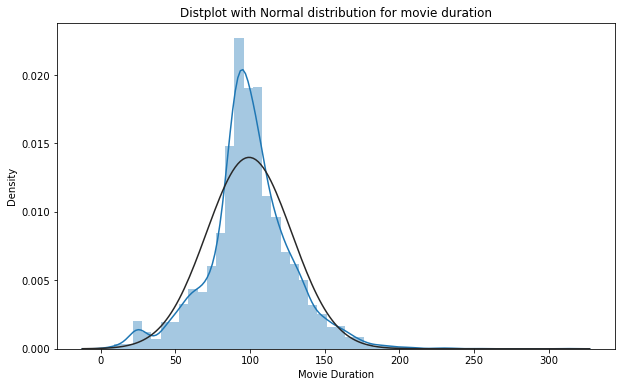

In [293]:
from scipy import stats
movie_duration = data[["duration"]][data["type"]=="Movie"]
#tv_duration.reset_index(inplace=True)

movie_duration["duration"] = [str(x).split()[0] for x in movie_duration["duration"]]

plt.figure(figsize=(10,6))
plt.title("Distplot with Normal distribution for movie duration")
plt.xlabel("Movie Duration")
plt.ylabel("Density")
sns.distplot(movie_duration[["duration"]], fit = stats.norm)

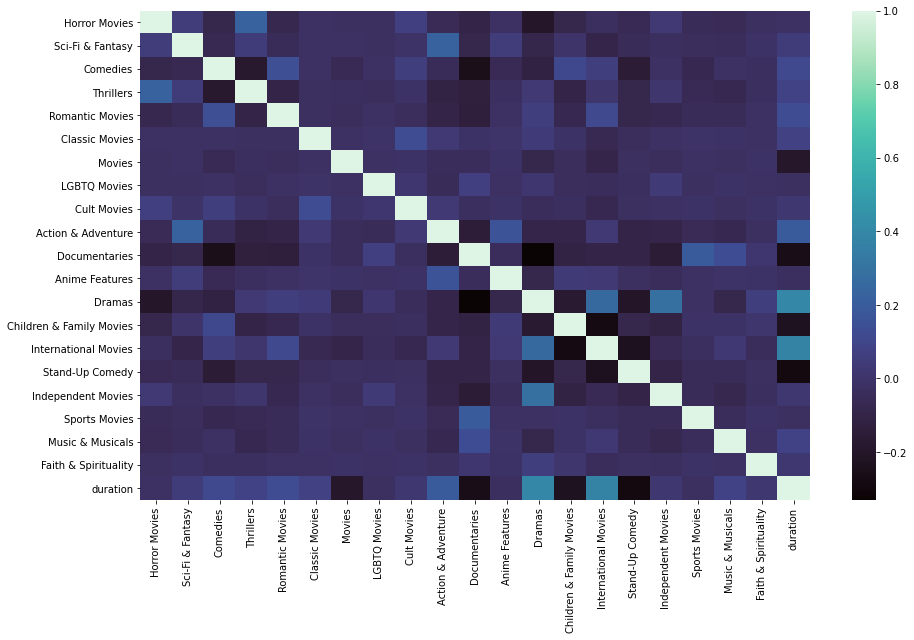

In [294]:
mg_duration = pd.merge(mg_data, data[["show_id","duration"]], how="left", on="show_id")
mg_duration["duration"] = [int(str(i).split()[0]) for i in mg_duration["duration"]]
#cmap = sns.diverging_palette(20, 10, as_cmap=True)
cmap = sns.color_palette("mako", as_cmap = True)
corr_m = mg_duration.corr()
plt.figure(figsize=(15,9))
sns.heatmap(corr_m, cmap = cmap)
#sns.heatmap(corr_m)

# Trend based on month of release

In [295]:
month_count=pd.DataFrame()
months = {"January":'01',"February":"02","March":"03","April":"04","May":"05","June":"06","July":"07","August":"08","September":"09","October":"10","November":"11","December":"12"}
month_count = data[["show_id"]][data.type=='Movie'].groupby(data.month_added).count()
month_count.rename(columns={"show_id":"Movies"}, inplace=True)
month_count["TV Shows"] = data[["show_id"]][data.type=='TV Show'].groupby(data.month_added).count()
month_count["Total"] = data[["show_id"]].groupby(data.month_added).count()

month_count = month_count.reindex(months.keys(), axis=0)

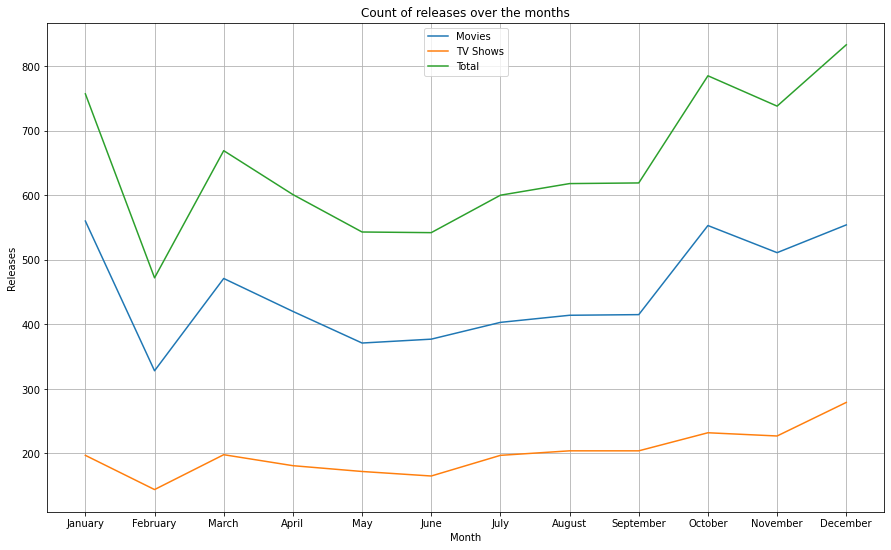

In [296]:
plt.figure(figsize=(15,9))
plt.plot(month_count)
plt.grid()
plt.title("Count of releases over the months")
plt.xlabel("Month")
plt.ylabel("Releases")
plt.legend(month_count.columns, loc="upper center")

# Distribution of movie and tv show ratings

In [252]:
data.rating.unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y', nan,
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

def gen_rating_df(data):
    rating_df = data[["rating","target_age","show_id"]].groupby(["rating","target_age"]).count().reset_index()
    rating_df = rating_df[rating_df["show_id"] != 0]
    rating_df.columns = ["rating","target_age","count"]
    rating_df = rating_df.sort_values("target_age")
    return rating_df

cmap = {"Kids":"green","Older Kids":"blue","Teens":"orange","Adults":"red"}

movie_rating_df = gen_rating_df(data[data.type == "Movie"])
tv_rating_df = gen_rating_df(data[data.type == "TV Show"])
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (20,16))
movie_rating_df.plot(kind = "bar", x = "rating", y = "count", xlabel = "Rating", ylabel = "Count", title = "Distribution of movie ratings", ax = ax1, color = list(movie_rating_df["target_age"].map(cmap)))
tv_rating_df.plot(kind = "bar", x = "rating", y = "count", xlabel = "Rating", ylabel = "Count", title = "Distribution of tv show ratings", ax = ax2, color = list(tv_rating_df["target_age"].map(cmap)))

In [297]:
import plotly.express as px
def gen_rating_df(data):
    rating_df = data[["rating","target_age","show_id"]].groupby(["rating","target_age"]).count().reset_index()
    rating_df = rating_df[rating_df["show_id"] != 0]
    rating_df.columns = ["rating","target_age","count"]
    rating_df = rating_df.sort_values("target_age")
    return rating_df

movie_rating_df = gen_rating_df(data[data.type == "Movie"])
tv_rating_df = gen_rating_df(data[data.type == "TV Show"])
ax1 = px.bar(movie_rating_df, x = "rating", y = "count", color = "target_age", title = "Distribution of movie ratings")
ax1.show()

ax2 = px.bar(tv_rating_df, x = "rating", y = "count", color = "target_age", title = "Distribution of tv show ratings")
ax2.show()

In [85]:
rating_df

,rating,target_age,count
1,NC-17,Adults,3
2,NR,Adults,79
5,R,Adults,663
8,TV-MA,Adults,1842
13,UR,Adults,5
0,G,Kids,39
7,TV-G,Kids,111
10,TV-Y,Kids,118
3,PG,Older Kids,247
9,TV-PG,Older Kids,505


In [256]:
    rating_df = data[["rating","target_age","show_id"]].groupby(["rating","target_age"]).count().reset_index()
    rating_df.columns = ["rating","target_age","count"]
    rating_df = rating_df.sort_values("target_age")

In [257]:
rating_df

,rating,target_age,count
0,G,Kids,39
40,TV-Y,Kids,281
36,TV-PG,Kids,0
32,TV-MA,Kids,0
28,TV-G,Kids,197
24,TV-14,Kids,0
48,TV-Y7-FV,Kids,0
20,R,Kids,0
16,PG-13,Kids,0
12,PG,Kids,0


# Count of releases based on country of production

In [259]:
country_data = data

In [308]:
country_data["country"] = country_data["country"].apply(lambda x:str(x).split(",")[0])
country_data["country"][country_data["country"]=="nan"] = country_data["country"].mode()[0]
country_data2 = country_data["show_id"].groupby(country_data["country"]).count().sort_values(ascending=False).reset_index()

<ipython-input-308-14150f13e031>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [309]:
country_data2.columns = ['country','count']

In [310]:

fig = px.bar(country_data2.iloc[:50,:], x = 'country', y = 'count')
fig.show()

# For the top 10 countries, explore what type of content they have been producing over the years

In [326]:
countries = list(country_data2.iloc[:10,0])

In [327]:
mg_year_country_df = pd.merge(mg_data, country_data[["show_id","country"]], how = "left", on = "show_id")

In [330]:
mg_year_country_df = mg_year_country_df[mg_year_country_df["country"].isin(countries)].reset_index(drop = True)

<ipython-input-335-d08fdd923c1c>:18: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



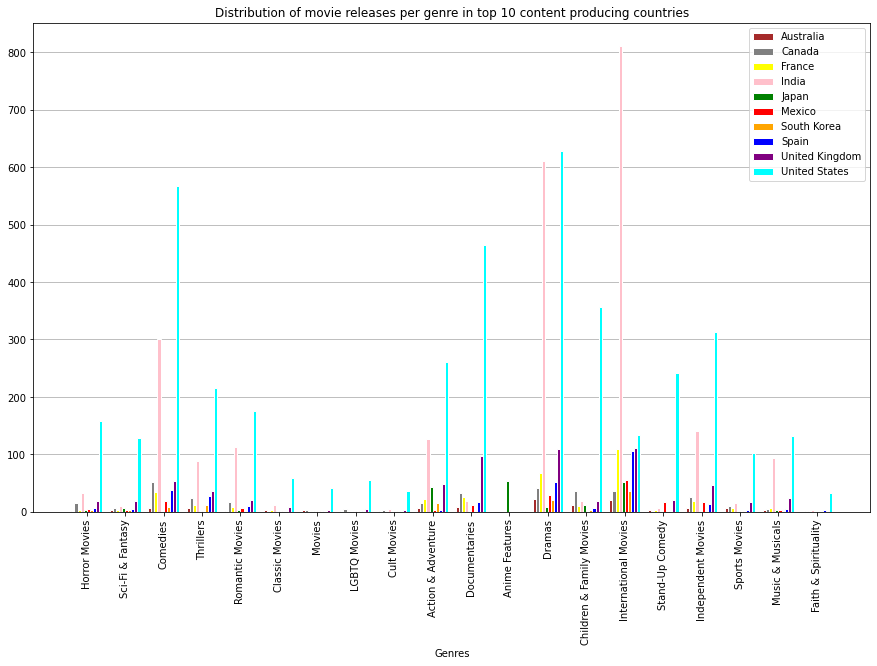

In [335]:
mg_country_df = mg_year_country_df.iloc[:,:-3].groupby(mg_year_country_df.country).sum()

fig = plt.figure(figsize=(15,9))
barwidth = 0.08
bars = [mg_country_df.iloc[0,:]]
r = [np.arange(len(bars[0]))]
#r = [np.arange(0,60,3)]
color = ["brown","grey","yellow","pink","green","red","orange","blue","purple","cyan"]
for col in range(1,len(mg_country_df.index)):
    bars.append(mg_country_df.iloc[col,:])
    r.append([x + barwidth for x in r[col-1]])
for i in range(len(bars)):
    plt.bar(r[i], bars[i], width = barwidth, edgecolor = "white",label = mg_country_df.index[i], color=color[i])
plt.xlabel("Genres")
plt.xticks([r + barwidth*((len(mg_country_df)-1)/2) for r in range(len(bars[0]))],list(mg_country_df.columns), rotation = 90)
plt.legend()
plt.title("Distribution of movie releases per genre in top 10 content producing countries")
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.grid(axis="y")
plt.show()

<ipython-input-336-ed545130077c>:20: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



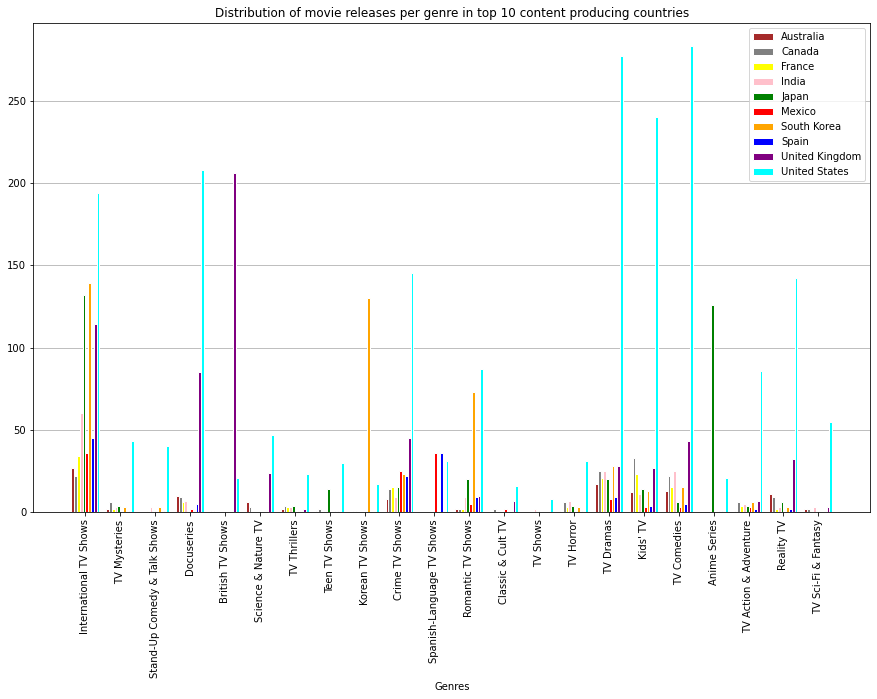

In [336]:
tvg_year_country_df = pd.merge(tvg_data, country_data[["show_id","country"]], how = "left", on = "show_id")
tvg_year_country_df = tvg_year_country_df[tvg_year_country_df["country"].isin(countries)].reset_index(drop = True)
tvg_country_df = tvg_year_country_df.iloc[:,:-3].groupby(tvg_year_country_df.country).sum()

fig = plt.figure(figsize=(15,9))
barwidth = 0.08
bars = [tvg_country_df.iloc[0,:]]
r = [np.arange(len(bars[0]))]
#r = [np.arange(0,60,3)]
color = ["brown","grey","yellow","pink","green","red","orange","blue","purple","cyan"]
for col in range(1,len(tvg_country_df.index)):
    bars.append(tvg_country_df.iloc[col,:])
    r.append([x + barwidth for x in r[col-1]])
for i in range(len(bars)):
    plt.bar(r[i], bars[i], width = barwidth, edgecolor = "white",label = tvg_country_df.index[i], color=color[i])
plt.xlabel("Genres")
plt.xticks([r + barwidth*((len(tvg_country_df)-1)/2) for r in range(len(bars[0]))],list(tvg_country_df.columns), rotation = 90)
plt.legend()
plt.title("Distribution of movie releases per genre in top 10 content producing countries")
ax = fig.add_subplot(1,1,1)
ax.set_axisbelow(True)
ax.grid(axis="y")
plt.show()

In [422]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
def tv_show_pie(tvg_country_df):
    labels = countries
    specs = [[{'type':'domain'} for i in range(0,4)] for j in range(0,6)]
    columns = tvg_country_df.columns
    tvg_country_df = tvg_country_df.reindex(labels, axis = 0)
    fig = make_subplots(rows = 6, cols = 4, specs=specs)
    domains = [
    {'x': [0.0, 0.22], 'y': [0.0, 0.15]},
    {'x': [0.0, 0.22], 'y': [0.17, 0.31]},
    {'x': [0.0, 0.22], 'y': [0.33, 0.47]},
    {'x': [0.0, 0.22], 'y': [0.49, 0.63]},
    {'x': [0.0, 0.22], 'y': [0.65, 0.79]},
    {'x': [0.0, 0.22], 'y': [0.81, 0.96]},
    {'x': [0.26, 0.48], 'y': [0.0, 0.15]},
    {'x': [0.26, 0.48], 'y': [0.17, 0.31]},
    {'x': [0.26, 0.48], 'y': [0.33, 0.47]},
    {'x': [0.26, 0.48], 'y': [0.49, 0.63]},
    {'x': [0.26, 0.48], 'y': [0.65, 0.79]},
    {'x': [0.26, 0.48], 'y': [0.81, 0.96]},
    {'x': [0.52, 0.76], 'y': [0.0, 0.15]},
    {'x': [0.52, 0.76], 'y': [0.17, 0.31]},
    {'x': [0.52, 0.76], 'y': [0.33, 0.47]},
    {'x': [0.52, 0.76], 'y': [0.49, 0.63]},
    {'x': [0.52, 0.76], 'y': [0.65, 0.79]},
    {'x': [0.52, 0.76], 'y': [0.81, 0.96]},
    {'x': [0.79, 1.00], 'y': [0.0, 0.15]},
    {'x': [0.79, 1.00], 'y': [0.17, 0.31]},
    {'x': [0.79, 1.00], 'y': [0.33, 0.47]},
    {'x': [0.79, 1.00], 'y': [0.49, 0.63]},
    {'x': [0.79, 1.00], 'y': [0.65, 0.79]},
    {'x': [0.79, 1.00], 'y': [0.81, 0.96]},
    ]
    for col in range(len(columns)):
        x = (col//4) + 1
        y = (col%4) + 1
        fig.add_trace(go.Pie(labels = labels, values = tvg_country_df.iloc[:,col], name = columns[col], domain = domains[col]), x, y)
        fig.update_traces(textinfo = "none")
    #fig.update_layout(title = "TV Show releases classified by different genres and countries", margin=dict(t=0, b=0, l=0, r=0))
    plt.tight_layout()
    fig.show()

In [423]:
tv_show_pie(tvg_country_df)

<Figure size 432x288 with 0 Axes>

In [425]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
def tv_show_pie(tvg_country_df):
    labels = countries
    specs = [[{'type':'domain'} for i in range(0,4)] for j in range(0,6)]
    columns = tvg_country_df.columns
    tvg_country_df = tvg_country_df.reindex(labels, axis = 0)
    domains = [
    {'x': [0.0, 0.22], 'y': [0.0, 0.15]},
    {'x': [0.0, 0.22], 'y': [0.17, 0.31]},
    {'x': [0.0, 0.22], 'y': [0.33, 0.47]},
    {'x': [0.0, 0.22], 'y': [0.49, 0.63]},
    {'x': [0.0, 0.22], 'y': [0.65, 0.79]},
    {'x': [0.0, 0.22], 'y': [0.81, 0.96]},
    {'x': [0.26, 0.48], 'y': [0.0, 0.15]},
    {'x': [0.26, 0.48], 'y': [0.17, 0.31]},
    {'x': [0.26, 0.48], 'y': [0.33, 0.47]},
    {'x': [0.26, 0.48], 'y': [0.49, 0.63]},
    {'x': [0.26, 0.48], 'y': [0.65, 0.79]},
    {'x': [0.26, 0.48], 'y': [0.81, 0.96]},
    {'x': [0.52, 0.76], 'y': [0.0, 0.15]},
    {'x': [0.52, 0.76], 'y': [0.17, 0.31]},
    {'x': [0.52, 0.76], 'y': [0.33, 0.47]},
    {'x': [0.52, 0.76], 'y': [0.49, 0.63]},
    {'x': [0.52, 0.76], 'y': [0.65, 0.79]},
    {'x': [0.52, 0.76], 'y': [0.81, 0.96]},
    {'x': [0.79, 1.00], 'y': [0.0, 0.15]},
    {'x': [0.79, 1.00], 'y': [0.17, 0.31]},
    {'x': [0.79, 1.00], 'y': [0.33, 0.47]},
    {'x': [0.79, 1.00], 'y': [0.49, 0.63]}
    ]
    
    traces=[]
    
    for domain in range(0,len(domains)):
        trace = go.Pie(labels = labels,
                   values = tvg_country_df[domain],
                   domain = domains[domain],
                   hoverinfo = 'label+percent+name')
        traces.append(trace)

    layout = go.Layout(height = 600,
                   width = 600,
                   autosize = False,
                   title = 'Main title')
    fig = go.Figure(data = traces, layout = layout)
    py.iplot(fig, show_link = False)

In [377]:
import math
def country_genre_year(g_year_country_df, country):
    country_genre_year_df = g_year_country_df[g_year_country_df["country"] == country]
    country_genre_year_df = country_genre_year_df.iloc[:,:-3].groupby(country_genre_year_df["year_added"]).sum()
    n = math.ceil(len(country_genre_year_df.columns)/4)
    country_genre_year_df.plot(kind = "line", subplots = True, layout = (n,4), figsize = (20,18), title = country, legend = False, xlabel = "Year")
    [ax.legend(loc=0) for ax in plt.gcf().axes]

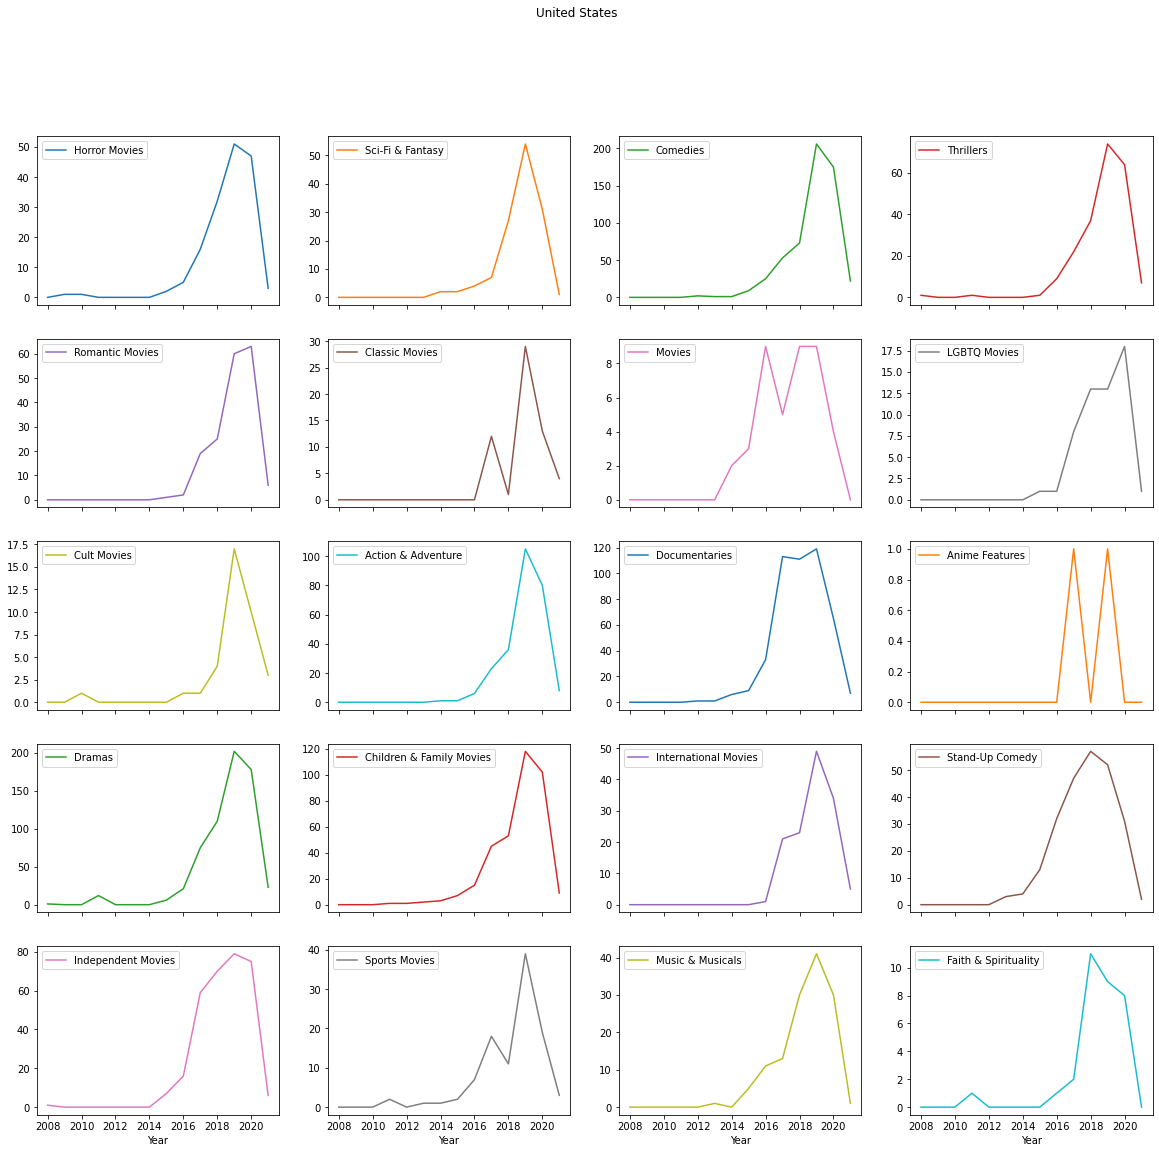

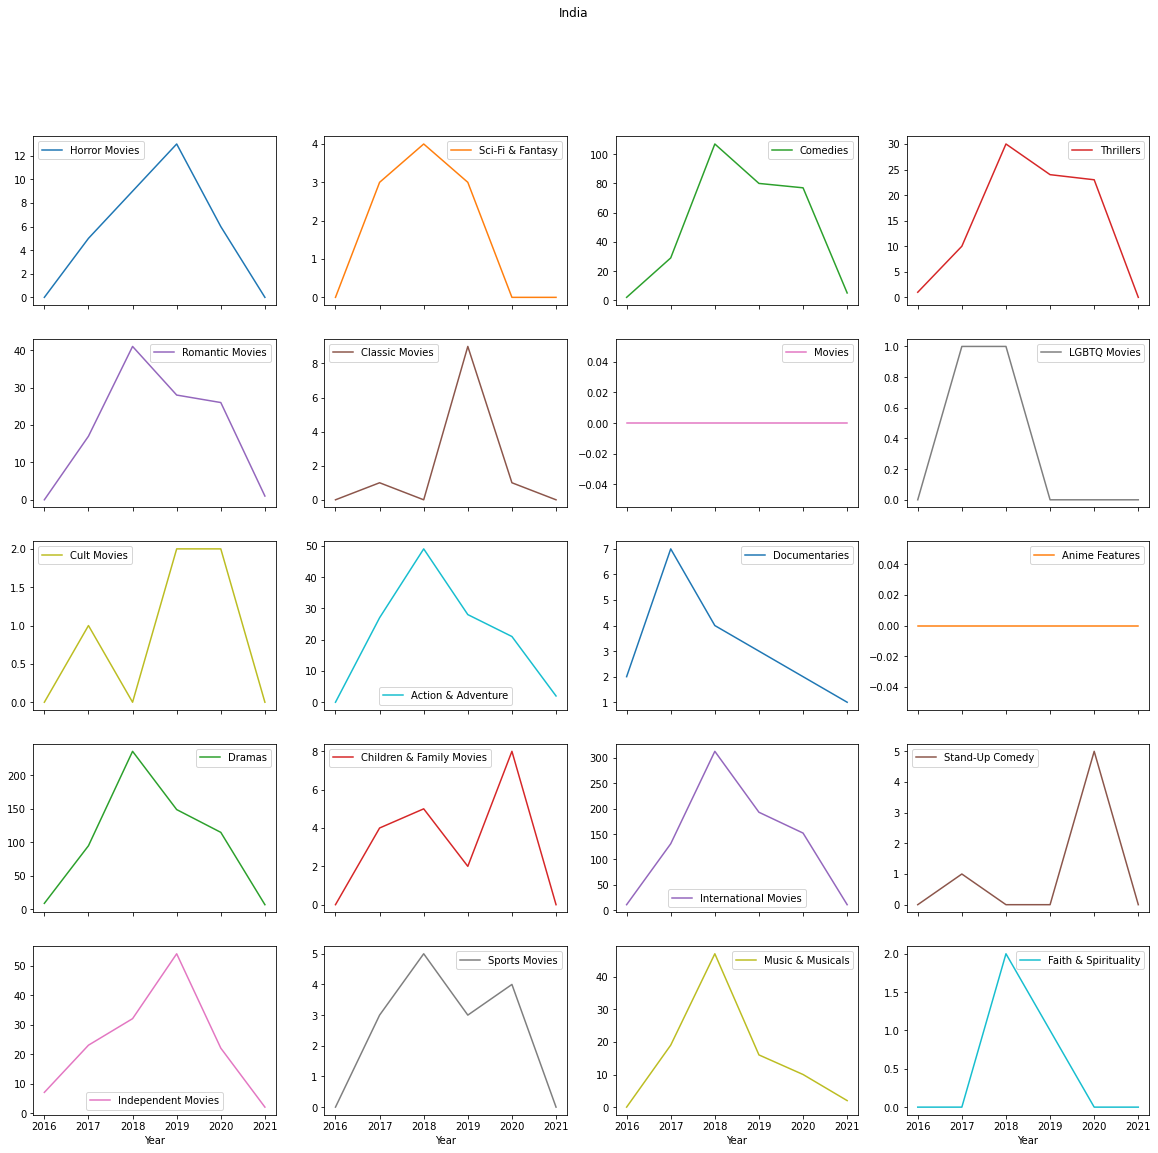

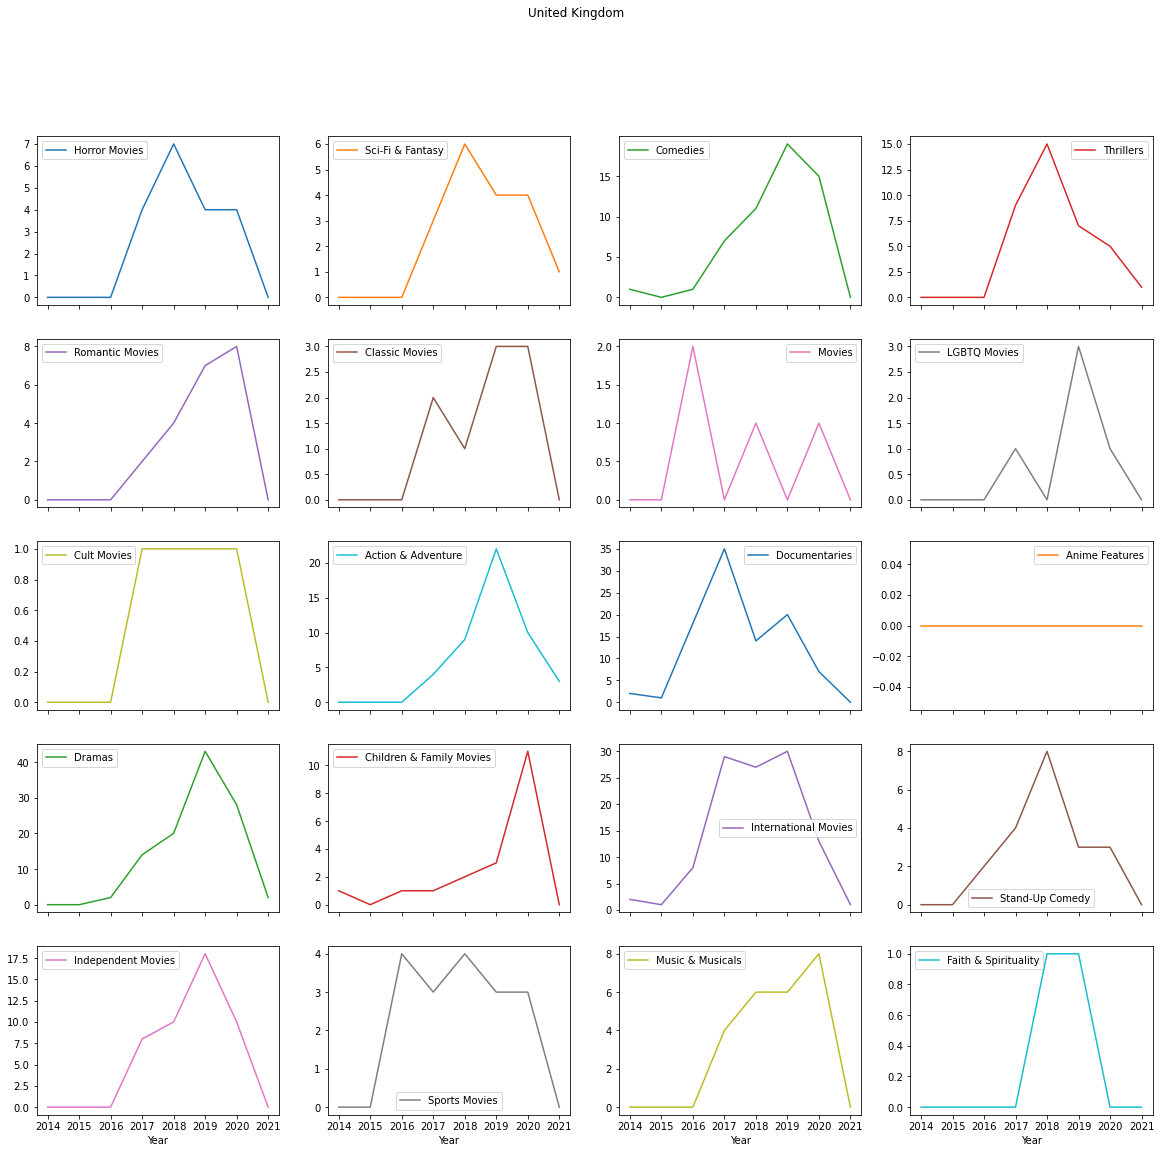

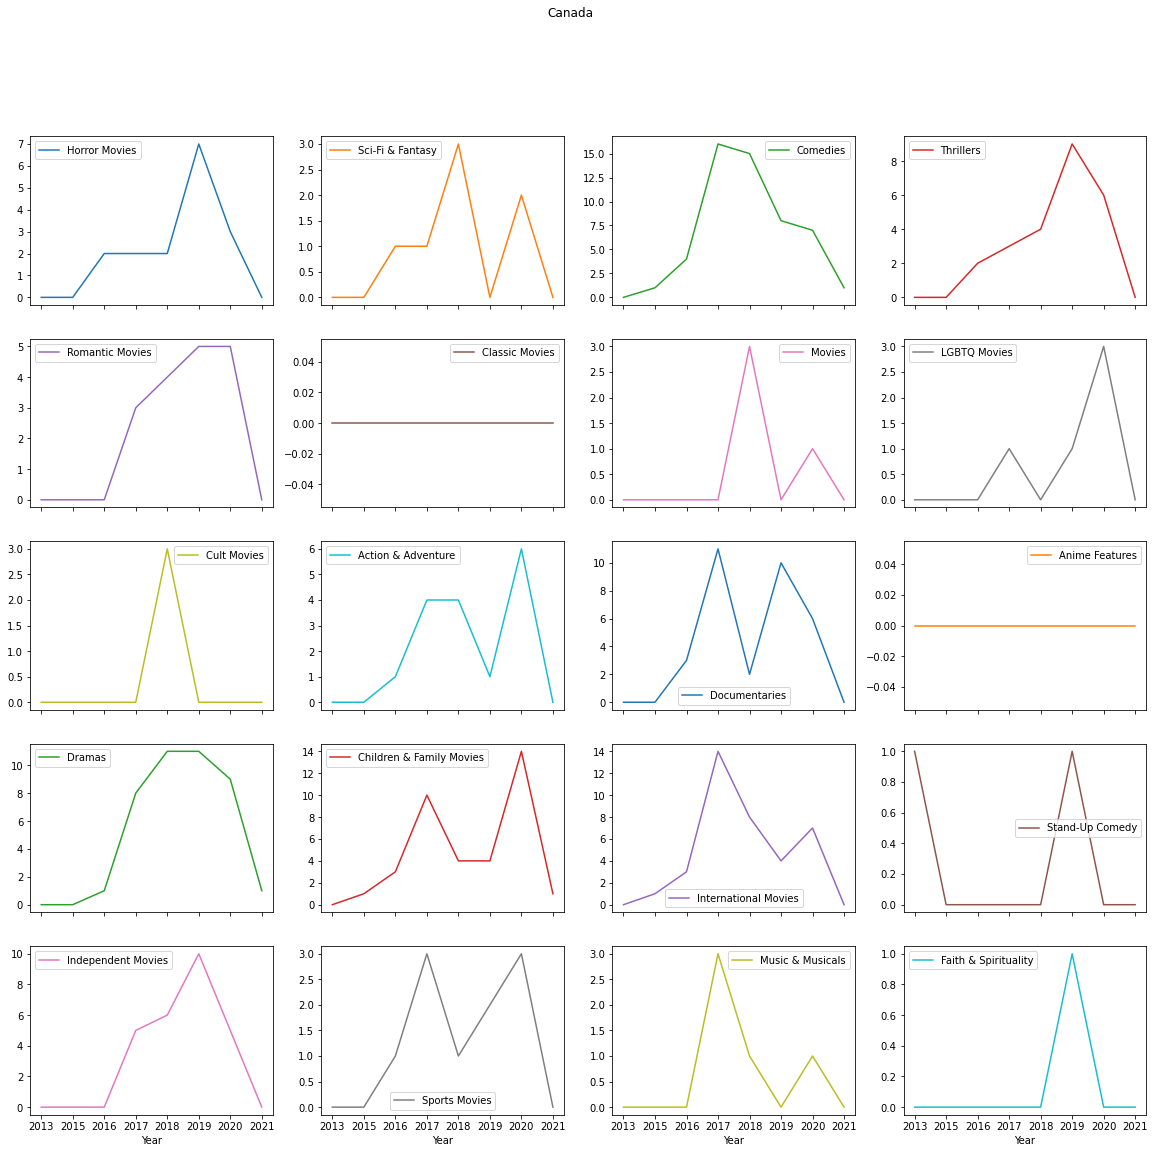

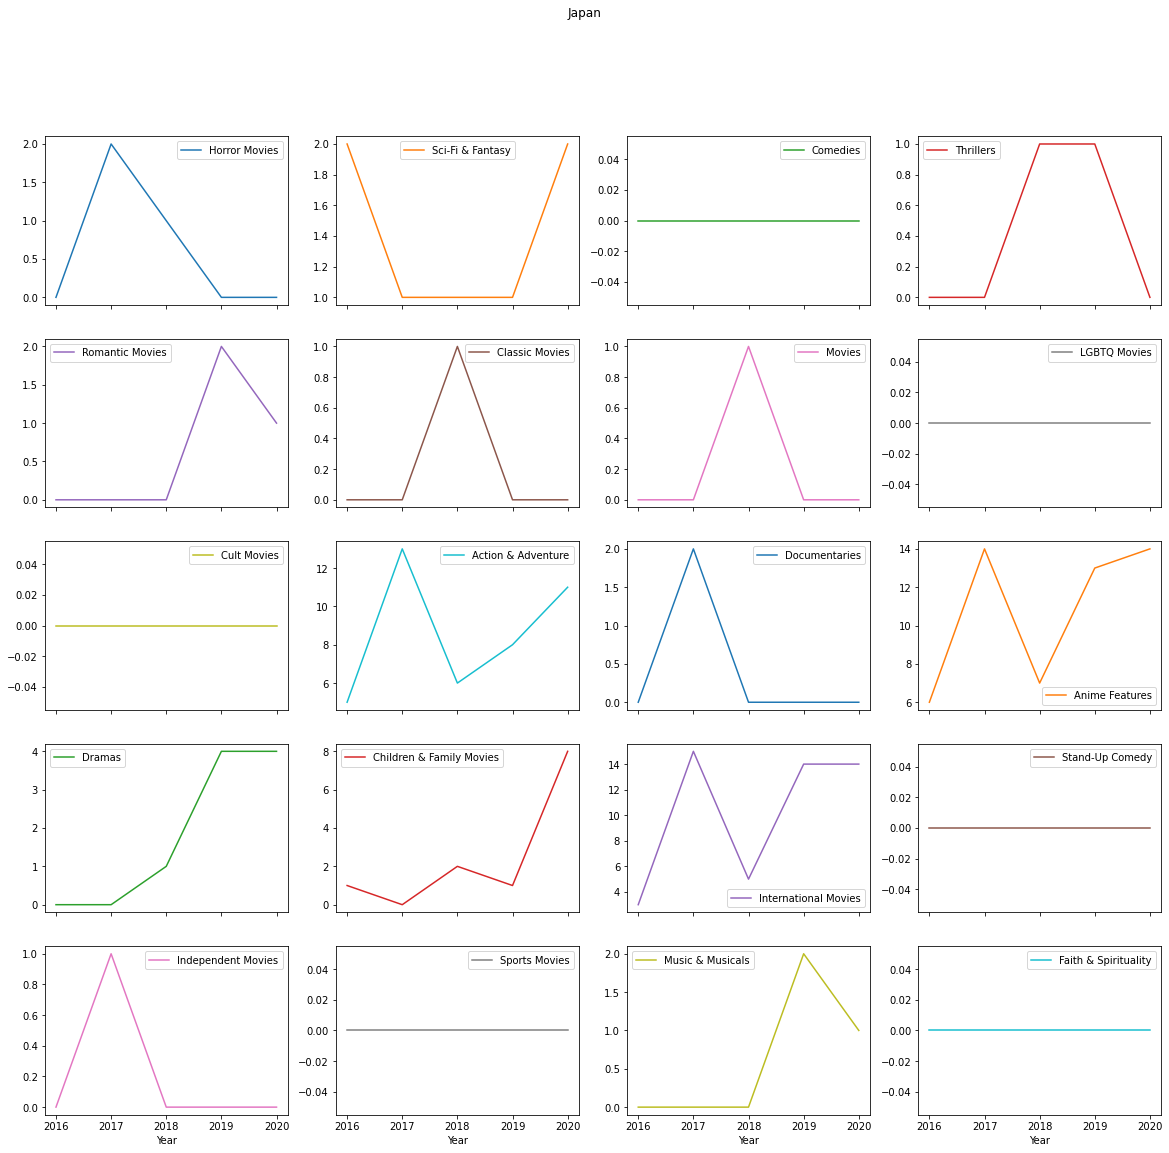

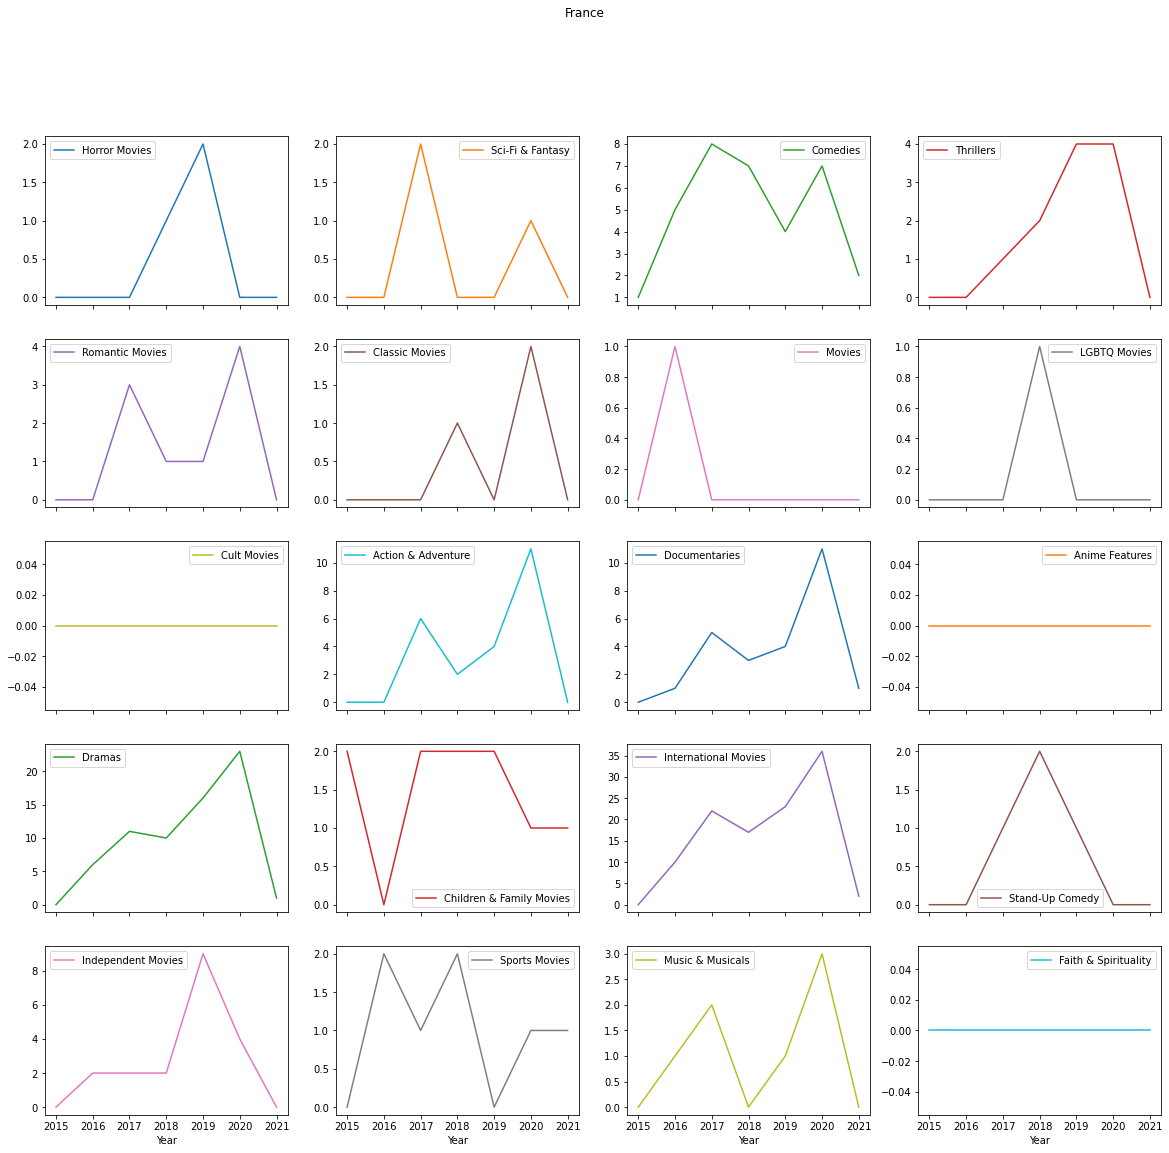

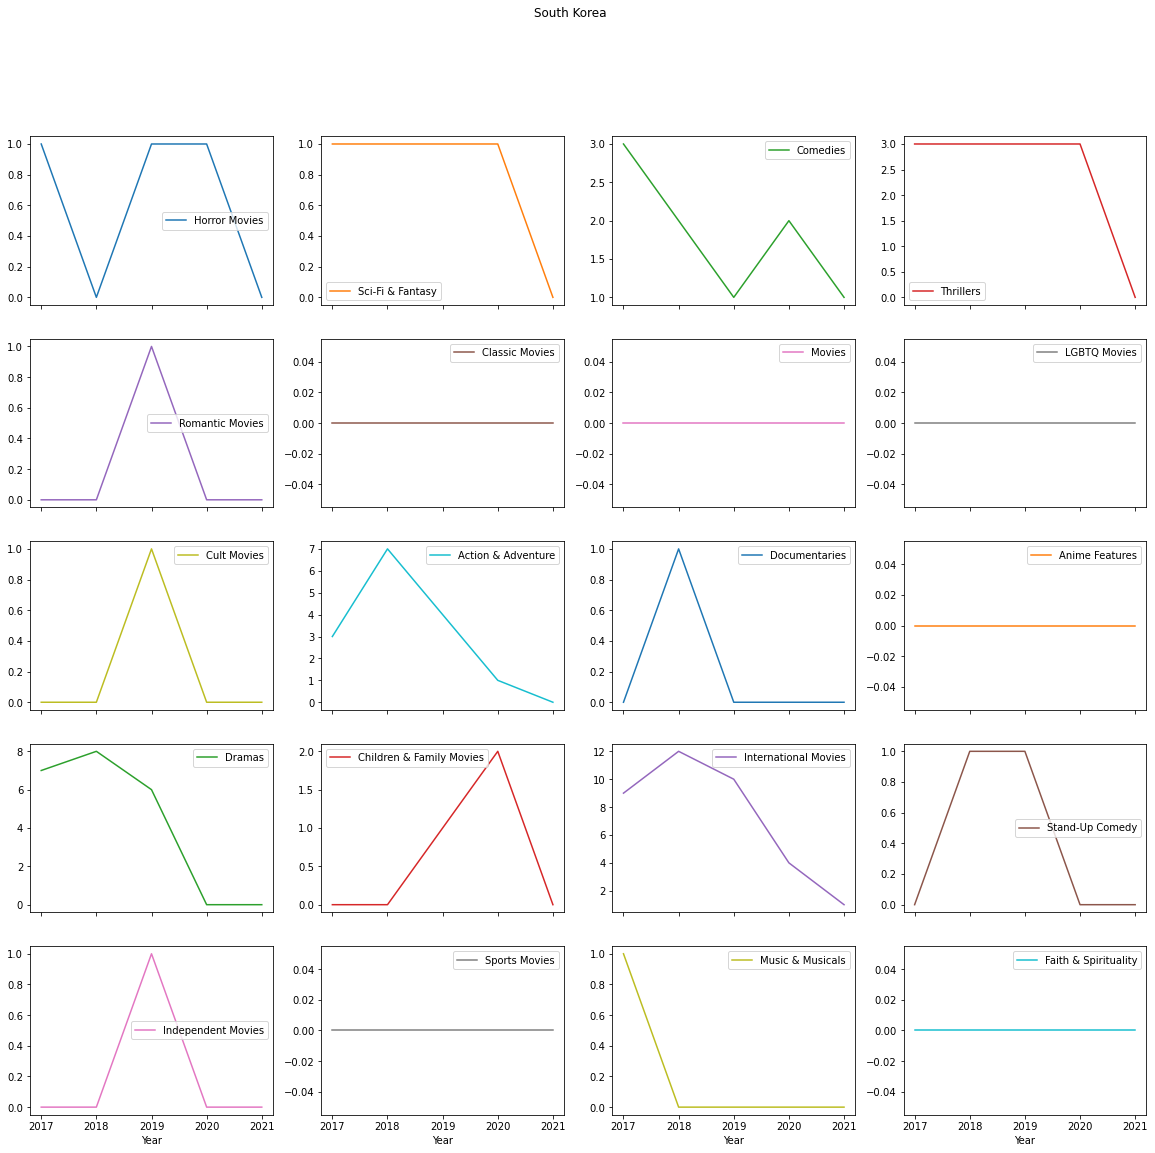

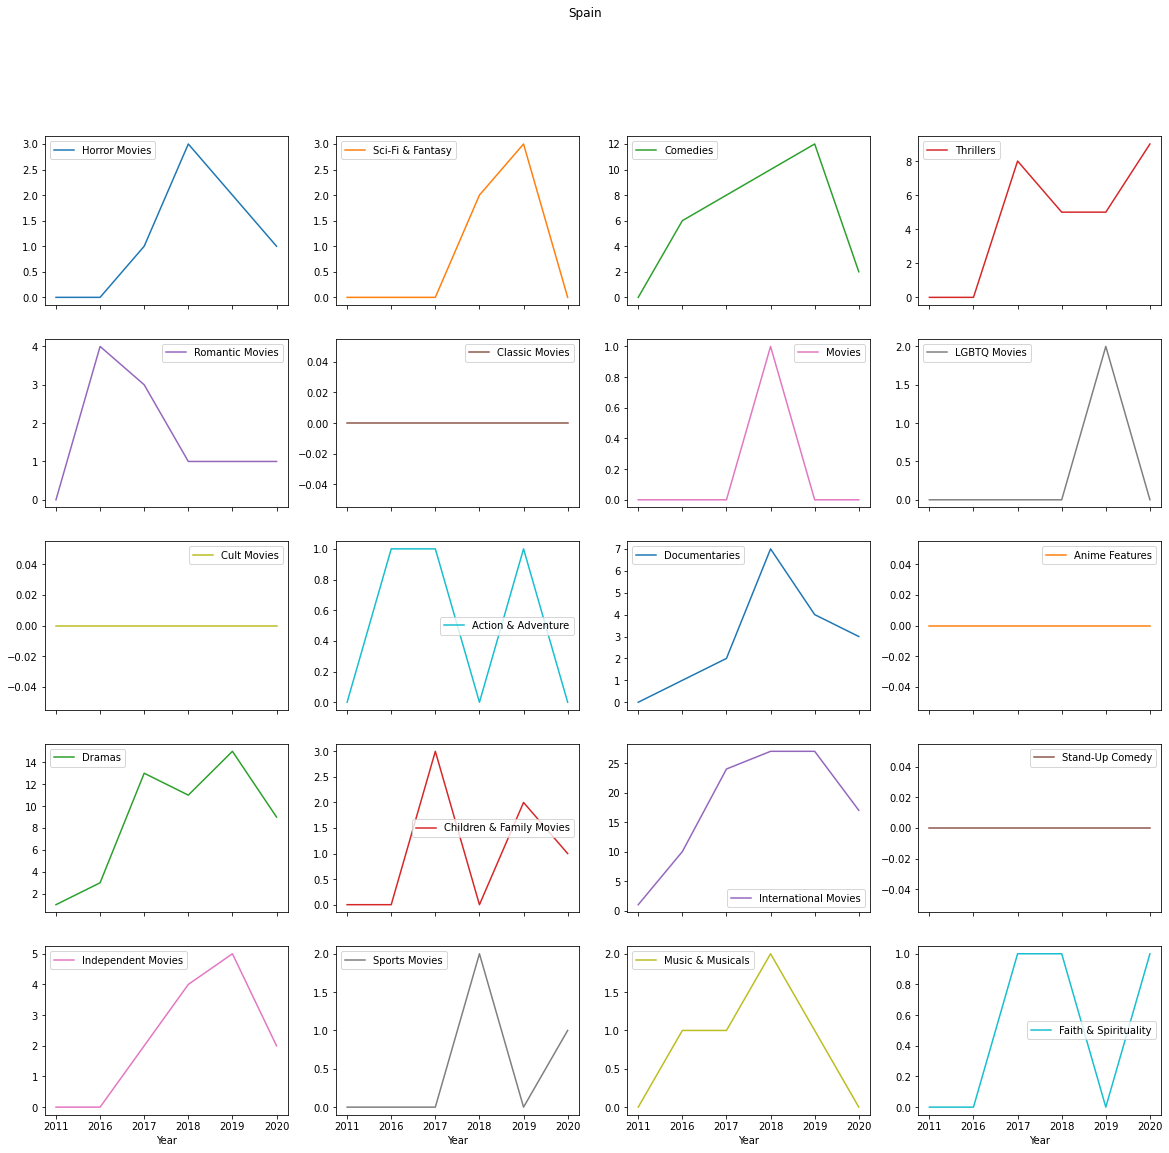

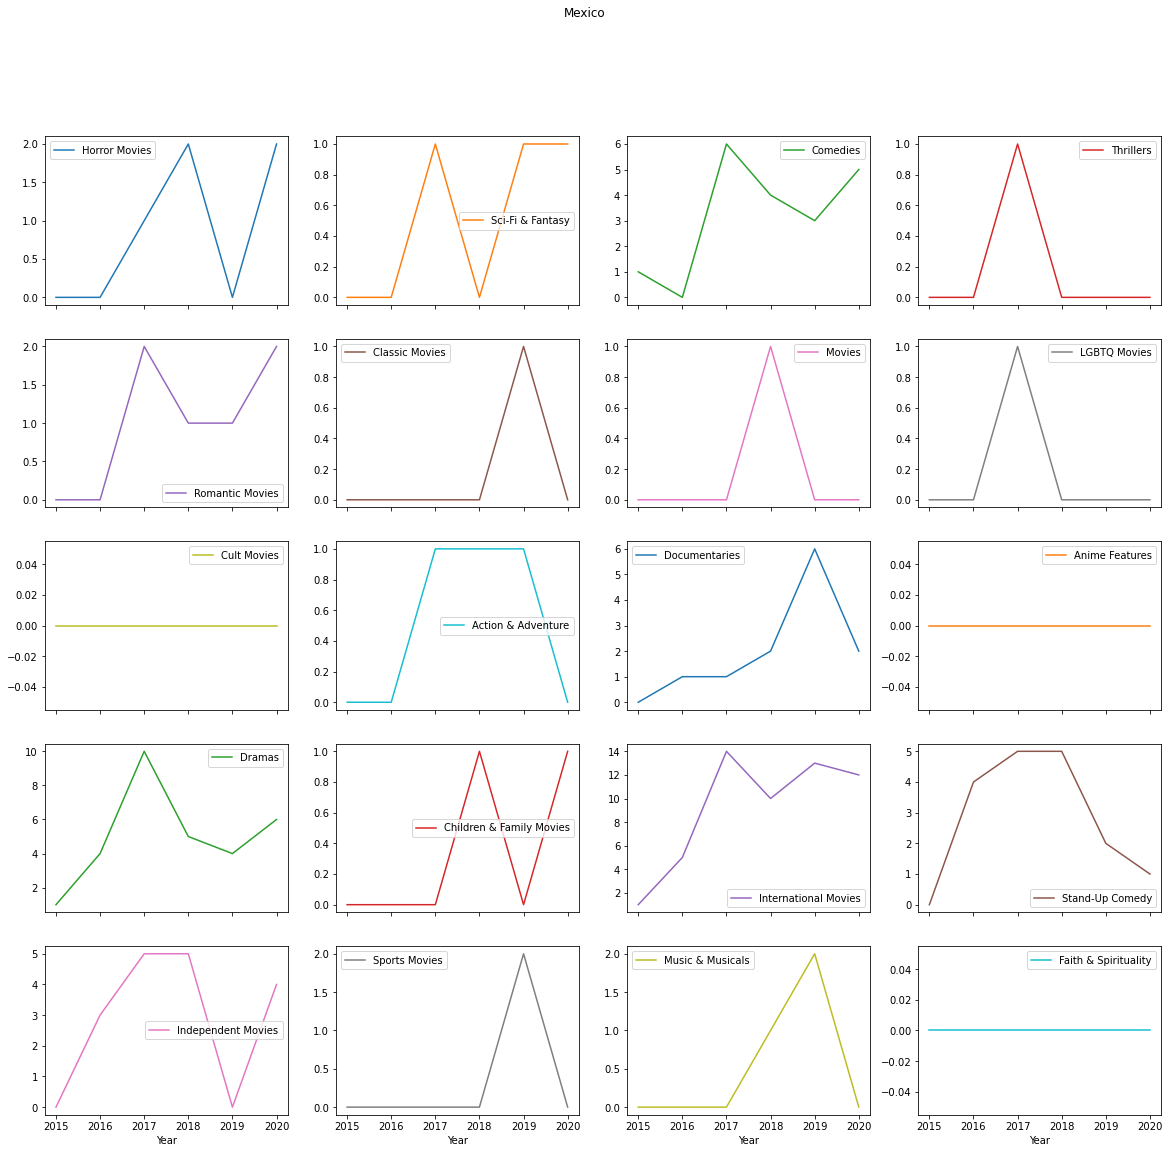

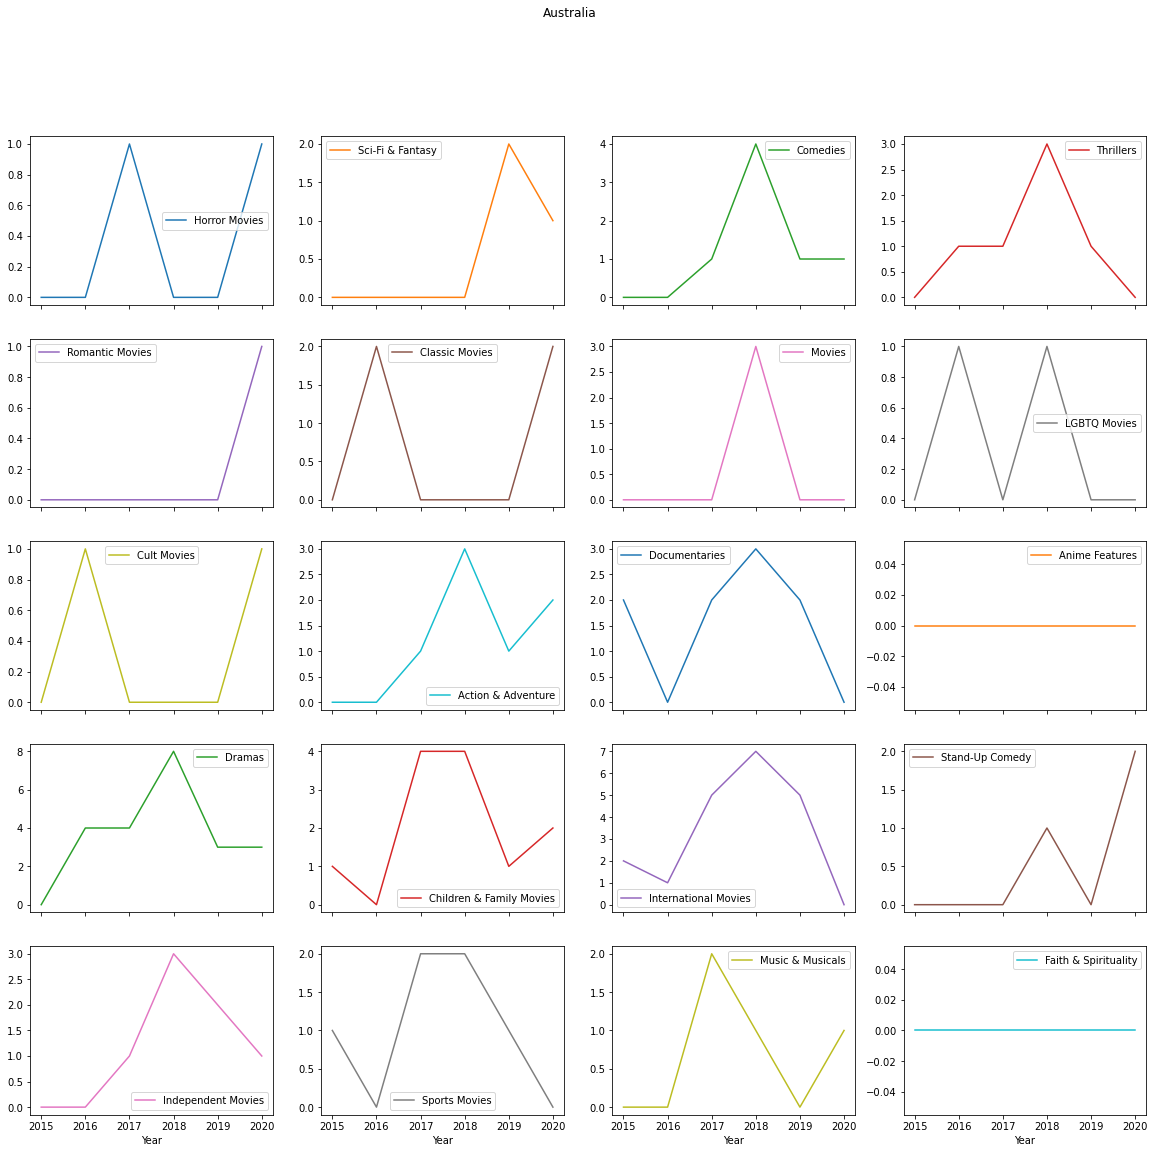

In [372]:
for country in countries:
    country_genre_year(mg_year_country_df, country)